In [1]:
import sys
sys.path.append("../") # go to parent dir to allow imports

from models import mnist_model
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ticks = [str(x) for x in range(10)]

def show(img):
    """Displays single mnist digit"""
    plt.imshow(img.reshape([28, 28]), cmap="gray")
    plt.show()
    
def show_with_var(img, prob, var):
    """Display single mnist digit next to the variance per class"""
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].imshow(img.reshape([28, 28]))
    axs[1].bar(ticks, prob)
    axs[2].bar(ticks, var)
    plt.show()
    
def save_img(path, img):
    imageio.imsave(path, img.reshape([28, 28]))
        
mnist = input_data.read_data_sets("../data/MNIST-data", one_hot=True)

Extracting ../data/MNIST-data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST-data/t10k-labels-idx1-ubyte.gz


In [19]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
print_tensors_in_checkpoint_file("model.ckpt", tensor_name="", all_tensors=True)

tensor_name:  mnist_model/conv1/conv2d/bias
[-0.0025852   0.0040056  -0.03670545  0.00408037 -0.01216792  0.00143437
 -0.00296173 -0.00137307 -0.00331717 -0.0006819   0.00125912  0.00204506
 -0.01130602  0.00276732 -0.00459944 -0.00024278  0.00653183 -0.0144094
 -0.01080251  0.0003786   0.0016897  -0.00308472 -0.0023036   0.01031559
 -0.00264781 -0.00272253  0.00390194  0.00912776  0.00533508 -0.00057335
 -0.00216232 -0.00096547]
tensor_name:  mnist_model/conv1/conv2d/kernel
[[[[  2.24126931e-02  -7.69103467e-02   7.22118765e-02   6.89437538e-02
      3.06703150e-02   1.44141202e-04   1.01265162e-02   4.23510224e-02
      7.59753806e-04   9.29100662e-02  -3.48465517e-02   9.95556042e-02
     -5.42801581e-02   8.18676353e-02   4.79563214e-02  -2.20094267e-02
     -9.07747373e-02  -3.68948616e-02  -1.56056285e-02  -6.67982772e-02
      1.12682663e-01   4.62686457e-02  -2.80979034e-02  -1.06350884e-01
     -2.02367902e-02   1.07137516e-01   4.30941395e-02  -5.88195808e-02
     -3.32143307

# Crafting Adversarial Examples

The adversarial image is created by projected gradient descent with the pretrained dropout model with no MC Dropout. (http://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/)

In [4]:
tf.reset_default_graph()
dropout_rate=0.0
learning_rate=0.001

x_hat = tf.Variable(tf.zeros((784))) # trainable image
x = tf.placeholder(tf.float32, 784) # the image will be fed into this placeholder
dropout_rate = tf.placeholder(tf.float32)

assign_op = tf.assign(x_hat, x)  # x_hat <- x

logits, probs = mnist_model.dropout_cnn_mnist_model(x_hat, dropout_rate, reuse=False)

y_hat = tf.placeholder(tf.int32, ())
labels = tf.one_hot(y_hat, 10)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])

optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[x_hat])
#optim_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=[x_hat])
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)
    
init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

# Initialize all variables and restore trained weights
variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:8]
saver = tf.train.Saver(var_list=variable_list)
saver.restore(sess, "mnist_dropout.ckpt")
    
def modify_to(img, target, steps=10000):
    print("Modifying image to {}".format(target))
    demo_epsilon = 0.3
    demo_target = target
    demo_steps = steps

    sess.run(assign_op, feed_dict={x: img})

    for i in range(demo_steps):
        # gradient descent step
        _, loss_value = sess.run(
            [optim_step, loss],
            feed_dict={dropout_rate: 0, y_hat: demo_target})
        # project step
        sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
        if (i+1) % 2500 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))
            #print(np.argmax(sess.run(probs, feed_dict={dropout_rate: 0.4})[0]))

    adv_img = sess.run(x_hat)

    show(adv_img)
    #show(adv_img - img)
    return adv_img

INFO:tensorflow:Restoring parameters from mnist_dropout.ckpt


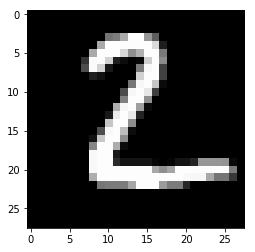

Modifying image to 5
step 2500, loss=0.254059
step 5000, loss=0.14925
step 7500, loss=0.113547
step 10000, loss=0.0949951


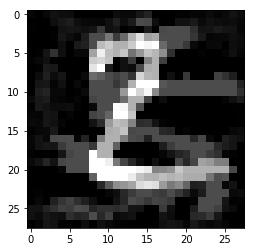

In [5]:
x_test = mnist.test.images
img = x_test[1]  # example image to be modified 
show(img)
adv_img = modify_to(img, 5, steps=10000)

In [11]:
imageio.imsave("adv_img.png", adv_img.reshape([28, 28]))
imageio.imsave("img.png", img.reshape([28, 28]))

In [33]:
adv_img = imageio.imread("adv_img.png").reshape(784)
img = imageio.imread("img.png").reshape(784)

# Adversarial Dropout Network

In [6]:
n_passes=50
def dropout_inference(adv_img, n_passes=10):
    sess.run(assign_op, feed_dict={x: adv_img})
    y = []
    for i in range(10):
        y.append(sess.run(probs, feed_dict={dropout_rate: 0.5})[0])

    fig, axs = plt.subplots(1, 2, figsize=[20, 10])
    axs[0].bar(ticks, np.array(y).var(axis=0))
    axs[0].set_title("Var")
    axs[1].bar(ticks, np.array(y).mean(axis=0))
    axs[1].set_title("Mean")

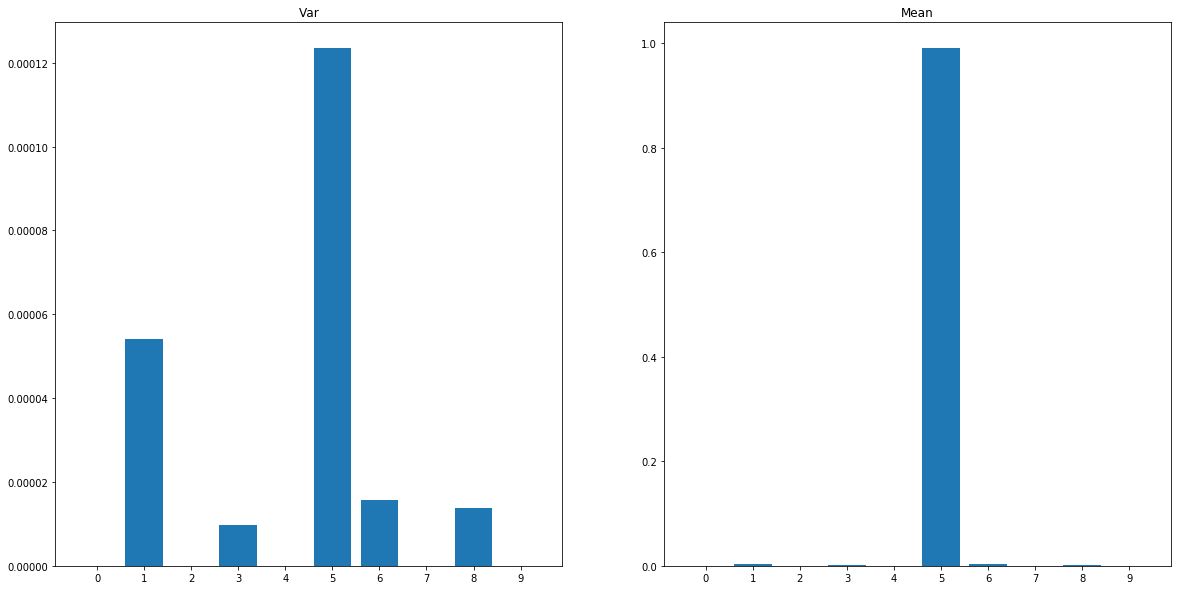

In [7]:
dropout_inference(adv_img)

# Adversarial Bootstrap Network

Is not helping at all.

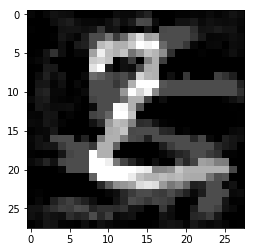

In [55]:
show(adv_img)

In [24]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")

16

In [31]:
tf.reset_default_graph()

#x_hat = tf.Variable(tf.zeros((784))) # trainable image
x_data = tf.placeholder(tf.float32, 784) # the image will be fed into this placeholder
dropout_rate = tf.placeholder(tf.float32)

heads = mnist_model.bootstrap_cnn_mnist_model(x_data, dropout_rate)

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

variable_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="mnist")[:16]
saver = tf.train.Saver(var_list=variable_list)
saver.restore(sess, "mnist_boostrap.ckpt")

INFO:tensorflow:Restoring parameters from mnist_boostrap.ckpt


Text(0.5,1,u'Mean')

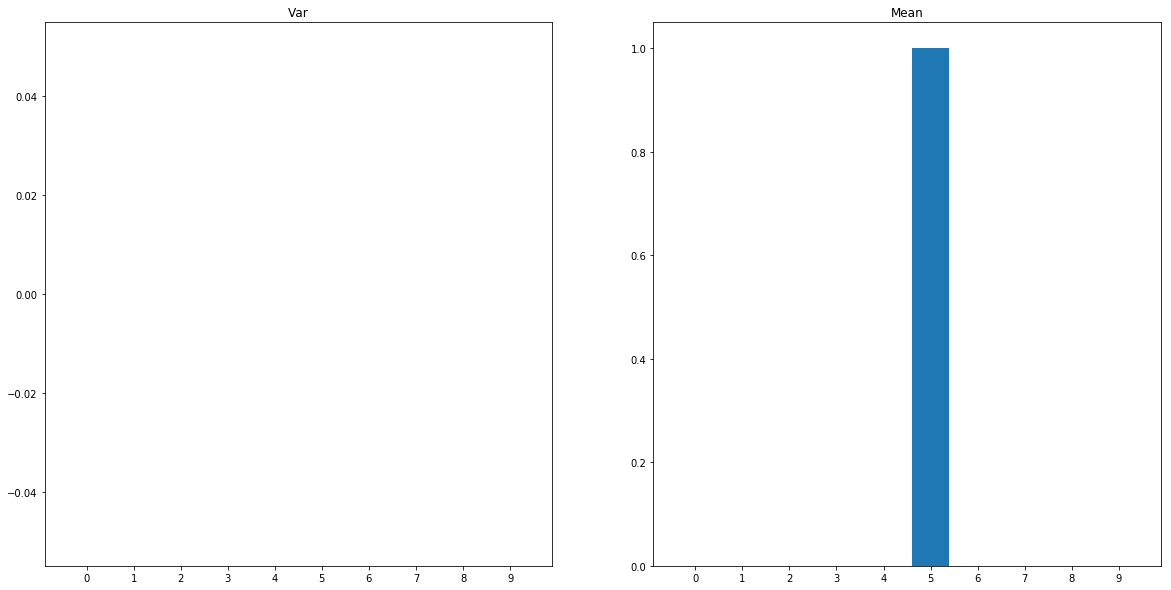

In [53]:
ys = []
for i, head in enumerate(heads):
    logits, class_prob = head
    y = sess.run(class_prob, feed_dict={x_data: adv_img, dropout_rate: 0.0})[0]
    ys.append(y)

fig, axs = plt.subplots(1, 2, figsize=[20, 10])
axs[0].bar(ticks, np.array(ys).var(axis=0))
axs[0].set_title("Var")
axs[1].bar(ticks, np.array(ys).mean(axis=0))
axs[1].set_title("Mean")